# RecGAN Voxel Output
## This notebook converts the output .mat file from the RecGAN network to a voxel .obj format for use in meshviewer.

In [1]:
# Importing Dependancies for functions
import os
import numpy as np
import scipy.io
import tensorflow as tf
import tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Defining functions for conversion of file type
## Converts numpy array to mesh .obj points
def voxel2mesh(voxels, surface_view):
    cube_verts = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0],
                  [1, 1, 1]]  # 8 points

    cube_faces = [[0, 1, 2], [1, 3, 2], [2, 3, 6], [3, 7, 6], [0, 2, 6], [0, 6, 4], [0, 5, 1],
                  [0, 4, 5], [6, 7, 5], [6, 5, 4], [1, 7, 3], [1, 5, 7]]  # 12 face

    cube_verts = np.array(cube_verts)
    cube_faces = np.array(cube_faces) + 1

    scale = 0.01
    cube_dist_scale = 1.1
    verts = []
    faces = []
    curr_vert = 0

    positions = np.where(voxels > 0.3)
    voxels[positions] = 1
    for i, j, k in zip(*positions):
        # identifies if current voxel has an exposed face
        if not surface_view or np.sum(voxels[i-1:i+2, j-1:j+2, k-1:k+2]) < 27:
            verts.extend(scale * (cube_verts + cube_dist_scale * np.array([[i, j, k]])))
            faces.extend(cube_faces + curr_vert)
            curr_vert += len(cube_verts)

    return np.array(verts), np.array(faces)

# Saves the .obj file
def write_obj(filename, verts, faces):
    """ write the verts and faces on file."""
    with open(filename, 'w') as f:
        # write vertices
        f.write('g\n# %d vertex\n' % len(verts))
        for vert in verts:
            f.write('v %f %f %f\n' % tuple(vert))

        # write faces
        f.write('# %d faces\n' % len(faces))
        for face in faces:
            f.write('f %d %d %d\n' % tuple(face))

# Function called to convert the format of the output and save the file.
def voxel2obj(filename, pred, surface_view = True):
    verts, faces = voxel2mesh(pred, surface_view)
    write_obj(filename, verts, faces)
    return  verts, faces


In [3]:
# Setting the variable for the saved output from RecGAN network

result_path = ('/home/josh/overtrain/no_test_train_split/X_Y_pred_999_00000.mat')
output = scipy.io.loadmat(result_path)


In [4]:
# Extracting the boolean numpy arrays for the RecGAN input batches, prediction and ground truth
x_sample = output['X_test']  # Input from R2N2 network
y_pred = output['Y_test_pred'] # RecGAN network prediction
y_true = output['Y_test_true'] # RecGAN ground truth

In [5]:
# Verifying the shape is a follows [batch_size, x, y, z , T/F]
x_sample.shape

(4, 64, 64, 64, 1)

In [6]:
# Saving the predicted output array as an .obj file for viewing in MeshViewer
voxel2obj('overtrained_nosplit_test_0.obj', y_pred[0,:,:,:,0])

(array([[0.   , 0.847, 0.825],
        [0.   , 0.847, 0.835],
        [0.   , 0.857, 0.825],
        ...,
        [2.815, 2.805, 2.804],
        [2.815, 2.815, 2.794],
        [2.815, 2.815, 2.804]]), array([[      1,       2,       3],
        [      2,       4,       3],
        [      3,       4,       7],
        ...,
        [1122327, 1122326, 1122325],
        [1122322, 1122328, 1122324],
        [1122322, 1122326, 1122328]]))

In [7]:

# function used to plot the reconstruction in the notebook

def plotFromVoxels(voxels,title=''):
    if len(voxels.shape)>3:
        x_d = voxels.shape[0]
        y_d = voxels.shape[1]
        z_d = voxels.shape[2]
        v = voxels[:,:,:,0]
        v = np.reshape(v,(x_d,y_d,z_d))
    else:
        v = voxels
        x, y, z = v.nonzero()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        #plt.show()
        plt.title(title)
        from matplotlib.pyplot import show
        show


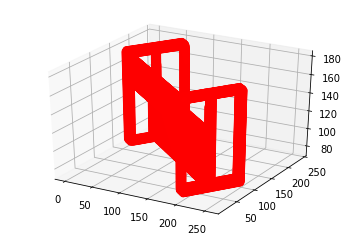

In [8]:
# Rough plot of the volex reconstruction in Matplotlib (not very usefull unless the reconstruction is poor)
%matplotlib inline
plotFromVoxels(y_true[2,:,:,:,0])
plt.show()